# Multi-Agent Systems with LangGraph

**Learning Objectives:**
- Understand when to use multiple agents vs one complex agent
- Build supervised multi-agent systems (orchestrator pattern)
- Implement collaborative agents (handoff pattern)
- Manage state across multiple agents

**Prerequisites:** Notebooks 01, 02, 03, 04

---

## Section 1: Why Multiple Agents?

### The Single Agent Problem

A single agent handling everything becomes:
- **Complicated** - Too many tools and responsibilities
- **Slow** - Has to think about everything
- **Error-prone** - Jack-of-all-trades, master of none
- **Hard to debug** - Where did it go wrong?

### Multi-Agent Solution

Split work among **specialized agents**:

```
User: "Research Python and write a report"

SINGLE AGENT:
  One agent does everything
  ❌ Complex, slow

MULTI-AGENT:
  Researcher Agent → Finds information
  Writer Agent → Creates report
  Editor Agent → Polishes output
  ✅ Specialized, modular, debuggable
```

### Benefits

1. **Specialization** - Each agent expert in one thing
2. **Modularity** - Easy to add/remove agents
3. **Easier debugging** - Know which agent failed
4. **Scalability** - Add agents as needs grow

### When to Use

**Single Agent:**
- ✅ Simple, focused tasks
- ✅ Few tools (1-3)
- ✅ One clear skill needed

**Multiple Agents:**
- ✅ Complex workflows
- ✅ Multiple domains/skills
- ✅ Tasks needing collaboration
- ✅ Quality needs multiple perspectives

**Today you'll build 3 multi-agent patterns!**

---
## Section 2: Setup

In [1]:
# Install required packages
!pip install -q langgraph langchain langchain-openai python-dotenv

In [2]:
# Imports
from langgraph.graph import START, END, StateGraph, MessagesState
from langgraph.checkpoint.memory import MemorySaver
from langgraph.prebuilt import ToolNode
from langchain_core.messages import HumanMessage, AIMessage, SystemMessage
from langchain_core.tools import tool
from langchain_openai import ChatOpenAI
from dotenv import load_dotenv
from IPython.display import Image, display
from typing import Literal, TypedDict, Annotated
import operator
import os

print("✅ All imports successful")

✅ All imports successful


In [3]:
# Load API key
load_dotenv()
openai_api_key = os.getenv("OPENAI_API_KEY")

if not openai_api_key:
    raise ValueError("OPENAI_API_KEY not found!")

print("✅ API key loaded")

✅ API key loaded


In [4]:
# Initialize LLM
llm = ChatOpenAI(
    model="gpt-4o-mini",
    temperature=0.7,
    api_key=openai_api_key
)

print(f"✅ LLM initialized: {llm.model_name}")

✅ LLM initialized: gpt-4o-mini


---
## Section 3: Pattern 1 - Supervised Multi-Agent (Orchestrator)

### How It Works

A **supervisor agent** routes work to **specialist workers**:

```
User Query
   ↓
SUPERVISOR
   ↓
"This needs research" → RESEARCHER
                            ↓
                        Result back to SUPERVISOR
   ↓
"Now calculate" → CALCULATOR
                      ↓
                  Result back to SUPERVISOR
   ↓
"Done!" → Final Answer
```

The supervisor is like a **project manager** delegating to experts.

### Step 1: Create Specialist Tools

In [5]:
@tool
def research_tool(query: str) -> str:
    """
    Research information (simulated).
    
    Args:
        query: What to research
    """
    knowledge = {
        "python": "Python was created by Guido van Rossum in 1991. It emphasizes code readability.",
        "langgraph": "LangGraph is a library for building stateful, multi-actor applications with LLMs.",
        "multi-agent": "Multi-agent systems use multiple specialized agents working together."
    }
    
    for key, value in knowledge.items():
        if key in query.lower():
            return f"Research result: {value}"
    
    return "No research results found."

@tool
def calculator_tool(expression: str) -> str:
    """
    Perform calculations.
    
    Args:
        expression: Math expression to evaluate
    """
    try:
        result = eval(expression, {"__builtins__": {}}, {})
        return f"Calculation result: {result}"
    except Exception as e:
        return f"Calculation error: {str(e)}"

@tool
def writer_tool(topic: str) -> str:
    """
    Write content about a topic.
    
    Args:
        topic: What to write about
    """
    return f"Written content: Here's a brief summary about {topic}. [Content would be generated here]"

print("✅ Specialist tools created")

✅ Specialist tools created


### Step 2: Create Specialist Agents

In [6]:
# Custom state for multi-agent
class MultiAgentState(TypedDict):
    """State shared across all agents."""
    messages: Annotated[list, operator.add]  # Conversation history
    next_agent: str  # Which agent to call next

# Researcher agent
researcher_prompt = SystemMessage(content="""You are a research specialist.
Use research_tool to find information. Be thorough and factual.""")

researcher_llm = llm.bind_tools([research_tool])

def researcher_agent(state: MultiAgentState) -> dict:
    """Research specialist."""
    messages = [researcher_prompt] + state["messages"]
    response = researcher_llm.invoke(messages)
    
    # Execute tool if called
    if response.tool_calls:
        tool_call = response.tool_calls[0]
        result = research_tool.invoke(tool_call["args"])
        return {"messages": [AIMessage(content=f"🔬 Researcher: {result}")]}
    
    return {"messages": [response]}

# Calculator agent
calculator_prompt = SystemMessage(content="""You are a calculation specialist.
Use calculator_tool for all math. Be precise.""")

calculator_llm = llm.bind_tools([calculator_tool])

def calculator_agent(state: MultiAgentState) -> dict:
    """Calculation specialist."""
    messages = [calculator_prompt] + state["messages"]
    response = calculator_llm.invoke(messages)
    
    if response.tool_calls:
        tool_call = response.tool_calls[0]
        result = calculator_tool.invoke(tool_call["args"])
        return {"messages": [AIMessage(content=f"🔢 Calculator: {result}")]}
    
    return {"messages": [response]}

# Writer agent
writer_prompt = SystemMessage(content="""You are a writing specialist.
Create clear, engaging content based on provided information.""")

writer_llm = llm.bind_tools([writer_tool])

def writer_agent(state: MultiAgentState) -> dict:
    """Writing specialist."""
    messages = [writer_prompt] + state["messages"]
    response = writer_llm.invoke(messages)
    
    if response.tool_calls:
        tool_call = response.tool_calls[0]
        result = writer_tool.invoke(tool_call["args"])
        return {"messages": [AIMessage(content=f"✍️ Writer: {result}")]}
    
    return {"messages": [response]}

print("✅ Specialist agents created")

✅ Specialist agents created


### Step 3: Create Supervisor Agent

In [7]:
# Supervisor routing options
from pydantic import BaseModel, Field

class RouteDecision(BaseModel):
    """Decision on which agent to call next."""
    next_agent: Literal["researcher", "calculator", "writer", "FINISH"] = Field(
        description="Which specialist to call next, or FINISH if task is complete"
    )
    reasoning: str = Field(
        description="Brief explanation for this routing decision"
    )

supervisor_llm = llm.with_structured_output(RouteDecision)

def supervisor_agent(state: MultiAgentState) -> dict:
    """
    Supervisor decides which specialist to call next.
    """
    prompt = f"""You are a supervisor managing specialist agents.

Available specialists:
- researcher: Finds information
- calculator: Performs math
- writer: Creates content

Conversation so far:
{state['messages']}

Decide which specialist to call next, or FINISH if the task is complete."""
    
    response = supervisor_llm.invoke([HumanMessage(content=prompt)])
    
    print(f"\n👔 Supervisor: {response.reasoning}")
    print(f"   Routing to: {response.next_agent}\n")
    
    return {"next_agent": response.next_agent}

print("✅ Supervisor agent created")

✅ Supervisor agent created


### Step 4: Build Multi-Agent Graph

In [8]:
# Routing function
def route_to_agent(state: MultiAgentState) -> str:
    """Route based on supervisor's decision."""
    return state["next_agent"]

# Build graph
multi_agent_builder = StateGraph(MultiAgentState)

# Add all agents as nodes
multi_agent_builder.add_node("supervisor", supervisor_agent)
multi_agent_builder.add_node("researcher", researcher_agent)
multi_agent_builder.add_node("calculator", calculator_agent)
multi_agent_builder.add_node("writer", writer_agent)

# Start with supervisor
multi_agent_builder.add_edge(START, "supervisor")

# Supervisor routes to specialists or finishes
multi_agent_builder.add_conditional_edges(
    "supervisor",
    route_to_agent,
    {
        "researcher": "researcher",
        "calculator": "calculator",
        "writer": "writer",
        "FINISH": END
    }
)

# All specialists report back to supervisor
multi_agent_builder.add_edge("researcher", "supervisor")
multi_agent_builder.add_edge("calculator", "supervisor")
multi_agent_builder.add_edge("writer", "supervisor")

supervised_system = multi_agent_builder.compile()

print("✅ Supervised multi-agent system created")

✅ Supervised multi-agent system created


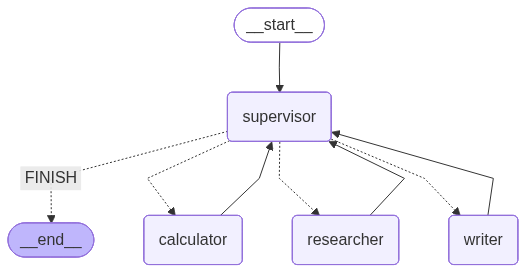

In [9]:
# Visualize
try:
    display(Image(supervised_system.get_graph().draw_mermaid_png()))
except Exception as e:
    print(f"Could not display graph: {e}")
    print("Graph: START → supervisor → [researcher|calculator|writer] → supervisor → END")

**🎨 Notice:** All specialists loop back to supervisor - centralized control!

### Test Supervised System

In [10]:
result = supervised_system.invoke({
    "messages": [HumanMessage(content="Research Python, then calculate 2**10")]
})

print("\n" + "="*70)
print("FINAL RESULT:")
print("="*70)
for msg in result["messages"]:
    if isinstance(msg, AIMessage):
        print(msg.content)
print("="*70 + "\n")


👔 Supervisor: The first part of the task is to research Python, which requires the researcher to find relevant information before performing the calculation.
   Routing to: researcher


👔 Supervisor: The research on Python has been completed. The next step is to perform the calculation 2**10.
   Routing to: calculator


👔 Supervisor: All tasks have been completed: the researcher provided information about Python, and the calculator performed the calculation of 2**10.
   Routing to: FINISH


FINAL RESULT:
🔬 Researcher: Research result: Python was created by Guido van Rossum in 1991. It emphasizes code readability.
🔢 Calculator: Calculation result: 1024



In [11]:
result = supervised_system.invoke({
    "messages": [HumanMessage(content="What is Python ?")]
})

print("\n" + "="*70)
print("FINAL RESULT:")
print("="*70)
for msg in result["messages"]:
    if isinstance(msg, AIMessage):
        print(msg.content)
print("="*70 + "\n")


👔 Supervisor: The human has asked for information about Python, which requires research to provide a comprehensive answer.
   Routing to: researcher


👔 Supervisor: The researcher has provided information about Python, but now we need to create content or an explanation based on that information.
   Routing to: writer


👔 Supervisor: The task is complete as the researcher provided necessary information about Python, and the writer created content summarizing it. No further action is required.
   Routing to: FINISH


FINAL RESULT:
🔬 Researcher: Research result: Python was created by Guido van Rossum in 1991. It emphasizes code readability.
✍️ Writer: Written content: Here's a brief summary about What is Python?. [Content would be generated here]



**🎯 Observe:** Supervisor delegates to multiple specialists in sequence!

---
## Section 4: Pattern 2 - Collaborative Multi-Agent (Handoff)

### How It Works

Agents **pass work directly** to each other in a pipeline, each with **specialized tools**:

```
User Query
   ↓
ANALYZER (with keyword extraction tool) → Extracts key topics
   ↓
RESEARCHER (with knowledge base search tool) → Finds detailed info
   ↓
FORMATTER (with markdown formatting tool) → Creates final output
   ↓
END
```

Like an **assembly line** - each agent has tools and adds value before passing forward.

### Key Difference from Orchestrator

- **Orchestrator:** Supervisor decides routing dynamically
- **Collaborative:** Fixed pipeline, agents pass work sequentially
- **Both:** Agents must have TOOLS to be "true agents"!

### Step 1: Create Specialized Tools for Collaborative Agents

In [12]:
# Tools for collaborative agents
@tool
def extract_keywords(text: str) -> str:
    """
    Extract key topics and keywords from text.
    
    Args:
        text: The text to analyze
    """
    # Simulated keyword extraction
    keywords = []
    important_terms = ["python", "langgraph", "multi-agent", "system", "agent", 
                      "tool", "research", "data", "analysis", "programming"]
    
    text_lower = text.lower()
    for term in important_terms:
        if term in text_lower:
            keywords.append(term)
    
    if keywords:
        return f"Keywords extracted: {', '.join(keywords)}"
    return "No significant keywords found"

@tool
def search_knowledge_base(keywords: str) -> str:
    """
    Search knowledge base for information about keywords.
    
    Args:
        keywords: Keywords to search for
    """
    # Simulated knowledge base
    knowledge_db = {
        "python": "Python is a high-level programming language created by Guido van Rossum in 1991. Known for readability and versatility in web development, data science, and AI.",
        "langgraph": "LangGraph is a library for building stateful, multi-actor applications with LLMs. It provides state management, graph-based workflows, and agent orchestration.",
        "multi-agent": "Multi-agent systems consist of multiple specialized autonomous agents that work together. Benefits include specialization, modularity, scalability, and parallel processing.",
        "tool": "Tools allow agents to interact with external systems and perform actions beyond text generation. Essential for true agent autonomy.",
        "programming": "Programming is the process of writing instructions for computers to execute. Involves problem-solving, algorithm design, and code implementation."
    }
    
    keywords_lower = keywords.lower()
    results = []
    
    for topic, info in knowledge_db.items():
        if topic in keywords_lower:
            results.append(f"**{topic.upper()}**: {info}")
    
    if results:
        return "\n\n".join(results)
    
    return "No detailed information found for these keywords."

@tool
def format_as_summary(content: str, style: str = "detailed") -> str:
    """
    Format content as a well-structured summary.
    
    Args:
        content: Content to format
        style: Format style (detailed, bullet, concise)
    """
    # Split on double newlines to preserve multi-paragraph content
    sections = [s.strip() for s in content.split('\n\n') if s.strip()]
    
    if style == "bullet":
        # Format each section as a bullet point
        formatted = "\n".join([f"• {section}" for section in sections])
    elif style == "concise":
        # Join with line breaks but keep structure
        formatted = "\n".join(sections)
    else:  # detailed (default)
        # Keep the original structure with proper spacing
        formatted = "\n\n".join(sections)
    
    return f"📋 Formatted Summary:\n{formatted}"

print("✅ Collaborative agent tools created")

✅ Collaborative agent tools created


### Step 2: Build Collaborative Agents with Tools

In [13]:
# Collaborative State
class CollaborativeState(TypedDict):
    """State for collaborative agents."""
    messages: Annotated[list, operator.add]  # Conversation history
    task: str  # Original task
    keywords: str  # From analyzer agent
    research_results: str  # From researcher agent
    formatted_output: str  # From formatter agent

# Agent 1: Analyzer with keyword extraction tool
analyzer_prompt = SystemMessage(content="""You are an analysis specialist.
Use extract_keywords tool to identify key topics from the task.
Be thorough in your analysis.""")

analyzer_llm = llm.bind_tools([extract_keywords])

def analyzer_agent(state: CollaborativeState) -> dict:
    """Analyzer agent with keyword extraction tool."""
    task = state["task"]
    messages = [
        analyzer_prompt,
        HumanMessage(content=f"Analyze this task and extract keywords: {task}")
    ]
    
    response = analyzer_llm.invoke(messages)
    
    # Execute tool if called
    keywords_result = ""
    if response.tool_calls:
        print("\n🔍 Analyzer: Using extract_keywords tool...")
        tool_call = response.tool_calls[0]
        keywords_result = extract_keywords.invoke(tool_call["args"])
        print(f"   {keywords_result}\n")
    else:
        keywords_result = response.content
        print(f"\n🔍 Analyzer: {keywords_result[:100]}...\n")
    
    return {
        "messages": [AIMessage(content=f"Analyzer findings: {keywords_result}")],
        "keywords": keywords_result
    }

# Agent 2: Researcher with knowledge base search tool
researcher_prompt = SystemMessage(content="""You are a research specialist.
Use search_knowledge_base tool to find comprehensive information about the keywords provided.
The tool will search for ALL keywords and return detailed results.""")

researcher_llm = llm.bind_tools([search_knowledge_base])

def researcher_agent(state: CollaborativeState) -> dict:
    """Researcher agent with knowledge base tool."""
    keywords = state["keywords"]
    
    # DIRECT APPROACH: Call the tool directly with the keywords from state
    # This bypasses the LLM's tendency to filter keywords
    print("🔬 Researcher: Using search_knowledge_base tool...")
    research_result = search_knowledge_base.invoke({"keywords": keywords})
    print(f"   Found results in knowledge base\n")
    
    return {
        "messages": [AIMessage(content=f"Research results: {research_result}")],
        "research_results": research_result
    }

# Agent 3: Formatter with summary formatting tool
formatter_prompt = SystemMessage(content="""You are a formatting specialist.
Use format_as_summary tool to create well-formatted output.
Make the summary clear and well-structured.""")

formatter_llm = llm.bind_tools([format_as_summary])

def formatter_agent(state: CollaborativeState) -> dict:
    """Formatter agent with summary formatting tool."""
    research = state["research_results"]
    
    # DIRECT APPROACH: Call the tool directly to preserve exact formatting
    # This prevents the LLM from modifying or stripping markdown formatting
    print("📝 Formatter: Using format_as_summary tool...")
    formatted_result = format_as_summary.invoke({"content": research, "style": "detailed"})
    print(f"   Formatted output created\n")
    
    return {
        "messages": [AIMessage(content=f"Final output: {formatted_result}")],
        "formatted_output": formatted_result
    }

print("✅ Collaborative agents created (with tools!)")

✅ Collaborative agents created (with tools!)


### Step 3: Build Collaborative Graph

In [14]:
# Build collaborative graph
collab_builder = StateGraph(CollaborativeState)

# Add agent nodes
collab_builder.add_node("analyzer", analyzer_agent)
collab_builder.add_node("researcher", researcher_agent)
collab_builder.add_node("formatter", formatter_agent)

# Linear pipeline: analyzer → researcher → formatter
collab_builder.add_edge(START, "analyzer")
collab_builder.add_edge("analyzer", "researcher")
collab_builder.add_edge("researcher", "formatter")
collab_builder.add_edge("formatter", END)

collaborative_system = collab_builder.compile()

print("✅ Collaborative multi-agent system created!")

✅ Collaborative multi-agent system created!


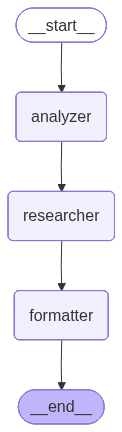

In [15]:
# Visualize collaborative system
try:
    display(Image(collaborative_system.get_graph().draw_mermaid_png()))
except Exception as e:
    print(f"Could not display graph: {e}")
    print("Graph: START → analyzer → researcher → formatter → END")

**🎨 Notice:** Linear pipeline where each agent has TOOLS and takes ACTIONS!

### Test Collaborative System

In [16]:
result = collaborative_system.invoke({
    "task": "Explain Python and multi-agent systems",
    "messages": []
})

print("\n" + "="*70)
print("FINAL FORMATTED OUTPUT:")
print("="*70)
print(result["formatted_output"])
print("="*70)
print("\n📊 AGENT ACTIVITY:")
print("- Analyzer: Used extract_keywords tool")
print("- Researcher: Used search_knowledge_base tool")
print("- Formatter: Used format_as_summary tool")
print("="*70 + "\n")


🔍 Analyzer: Using extract_keywords tool...
   Keywords extracted: python, multi-agent, system, agent

🔬 Researcher: Using search_knowledge_base tool...
   Found results in knowledge base

📝 Formatter: Using format_as_summary tool...
   Formatted output created


FINAL FORMATTED OUTPUT:
📋 Formatted Summary:
**PYTHON**: Python is a high-level programming language created by Guido van Rossum in 1991. Known for readability and versatility in web development, data science, and AI.

**MULTI-AGENT**: Multi-agent systems consist of multiple specialized autonomous agents that work together. Benefits include specialization, modularity, scalability, and parallel processing.

📊 AGENT ACTIVITY:
- Analyzer: Used extract_keywords tool
- Researcher: Used search_knowledge_base tool
- Formatter: Used format_as_summary tool



In [17]:
result = collaborative_system.invoke({
    "task": "Tell me about LangGraph and programming",
    "messages": []
})

print("\n" + "="*70)
print("FINAL FORMATTED OUTPUT:")
print("="*70)
print(result["formatted_output"])
print("="*70 + "\n")


🔍 Analyzer: Using extract_keywords tool...
   Keywords extracted: langgraph, programming

🔬 Researcher: Using search_knowledge_base tool...
   Found results in knowledge base

📝 Formatter: Using format_as_summary tool...
   Formatted output created


FINAL FORMATTED OUTPUT:
📋 Formatted Summary:
**LANGGRAPH**: LangGraph is a library for building stateful, multi-actor applications with LLMs. It provides state management, graph-based workflows, and agent orchestration.

**PROGRAMMING**: Programming is the process of writing instructions for computers to execute. Involves problem-solving, algorithm design, and code implementation.



**🎯 Observe:** Each agent uses its specialized tool to add value before passing to the next agent!

### 🎓 Key Takeaways - Collaborative Multi-Agent

**What makes this a multi-agent system:**

1. **Each agent has specialized tools:**
   - ✅ Analyzer → `extract_keywords` tool
   - ✅ Researcher → `search_knowledge_base` tool
   - ✅ Formatter → `format_as_summary` tool

2. **Agents make autonomous decisions:**
   - LLM decides WHEN to use tools
   - Checks `response.tool_calls`
   - Invokes tools based on task needs

3. **Agents take real actions:**
   - Extract keywords from text
   - Search knowledge bases
   - Format output styles

4. **Clear handoff pattern:**
   - Each agent processes and passes results forward
   - State carries information through pipeline
   - No supervisor needed (unlike orchestrator)

**When to use Collaborative vs Orchestrator:**

| Aspect | Collaborative | Orchestrator |
|--------|--------------|-------------|
| **Workflow** | Fixed pipeline | Dynamic routing |
| **Control** | Distributed | Centralized |
| **Best for** | Predictable stages | Varying tasks |
| **Example** | Data processing | Customer support |

**Both patterns require TRUE agents with tools!**

---
## Section 5: Summary

### What You Learned

1. **Why Multi-Agent**
   - Specialization vs generalization
   - Modularity and debuggability
   - When to split vs keep single agent

2. **Supervised Pattern (Orchestrator)**
   - Centralized orchestration with supervisor
   - Supervisor dynamically routes to specialist agents
   - Each specialist has dedicated tools
   - Best for tasks requiring dynamic delegation

3. **Collaborative Pattern (Handoff)**
   - Fixed linear pipeline workflow
   - Agents pass work sequentially
   - Each agent has specialized tools
   - Best for predictable, stage-based processing

### Pattern Comparison

| Aspect | Supervised (Orchestrator) | Collaborative (Handoff) |
|--------|--------------------------|------------------------|
| **Control** | Centralized (supervisor) | Distributed |
| **Routing** | Dynamic | Fixed pipeline |
| **Best For** | Varying task types | Predictable workflows |
| **Example** | Customer support routing | Data processing pipeline |
| **Complexity** | Medium | Low |

### What Makes TRUE Multi-Agent Systems

**All patterns share these requirements:**

1. ✅ **Tools bound to agents** - `llm.bind_tools([...])`
2. ✅ **Tool invocation logic** - Check `response.tool_calls` and invoke
3. ✅ **Autonomous decisions** - LLM decides when to use tools
4. ✅ **Real actions** - Agents interact with environment via tools

**Without tools = Multi-step LLM chain, NOT true multi-agent!**

### Key Takeaways

- **Start simple** - One agent first, split as complexity grows
- **Clear responsibilities** - Each agent has one specialized job
- **Choose the right pattern** - Match pattern to task structure
- **Tools are essential** - No tools means no true agency
- **Test individually** - Verify each agent works before integrating
- **Monitor carefully** - Multi-agent systems add complexity

### Design Principles

1. **Specialization over Generalization** - Narrow, focused agents perform better
2. **Explicit State Management** - Use TypedDict for clear state contracts
3. **Direct Tool Calls When Needed** - For reliability, call tools directly from state when appropriate
4. **Simple Tools** - Start with basic tools, add complexity only when needed

### 🎉 Module Complete!

You've mastered:
- ✅ Multi-Agent Architecture Patterns
- ✅ Tool-equipped Agent Design  
- ✅ Agent Coordination Strategies
- ✅ State Management Across Agents
- ✅ Production-Ready Patterns

**You're ready to build real-world multi-agent systems!**

---
## Section 6: Practice Exercise

### 🎯 Challenge: Build a Content Creation Pipeline

**Objective:** Create a collaborative multi-agent system that transforms raw ideas into polished blog posts.

### Requirements

Build a **3-agent pipeline** using the collaborative (handoff) pattern:

1. **Brainstormer Agent**
   - Tool: `generate_ideas(topic: str) -> str`
   - Generates 3-5 key points about the topic
   - Returns bullet points of ideas

2. **Writer Agent**  
   - Tool: `draft_content(ideas: str) -> str`
   - Takes ideas and writes a draft blog post
   - Returns structured content with intro, body, conclusion

3. **Editor Agent**
   - Tool: `improve_writing(draft: str) -> str`
   - Polishes the draft for clarity and flow
   - Returns final polished version

### Implementation Steps

1. **Define your tools** - Create the 3 tools above (simulated output is fine)
2. **Create custom state** - What fields do you need to pass between agents?
3. **Build the 3 agents** - Each with `llm.bind_tools([...])` and tool invocation logic
4. **Construct the graph** - Linear pipeline: brainstormer → writer → editor
5. **Test it** - Try: "Create a blog post about machine learning"

### Success Criteria

✅ All 3 agents have tools bound  
✅ State passes information through the pipeline  
✅ Each agent invokes its tool  
✅ Final output is polished content  
✅ Graph compiles and runs without errors

### Bonus Challenges

- **Add a 4th agent** - Fact-checker that validates claims

### Tips

- Start by copying the collaborative pattern structure
- Keep tools simple - they can return hardcoded examples
- Test each agent individually before connecting them
- Use print statements to see the pipeline flow

**Do it yourself. Good luck!** 🚀